CNN Testing different weight initialization - He, Random, Xavier

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the feature map after the convolution and pooling layers
        self._initialize_weights()

    def _initialize_weights(self):
        # Create a dummy input to calculate the size of the feature map
        dummy_input = torch.randn(1, 1, 28, 28)
        dummy_output = self.pool2(self.conv5(self.conv4(self.conv3(self.pool(self.conv2(self.pool(self.conv1(dummy_input))))))))
        self.feature_map_size = dummy_output.view(-1).size(0)

        self.fc1 = nn.Linear(self.feature_map_size, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(F.relu(self.conv5(x)))
        x = x.view(-1, self.feature_map_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Confirming the size of output after convolution layers
cnn_model = CNN()
print(cnn_model)

# Example of using a random tensor of size [batch_size, channels, height, width]
x = torch.randn(1, 1, 28, 28)  # Single batch, 1 channel, 28x28 image
output = cnn_model(x)
print(output.shape)  # Should be [1, 10]


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([1, 10])


CNN - Training using inbuilt functions

In [ ]:
def accuracy(output, y):
    predictions = np.argmax(output, axis=1)
    return np.mean(predictions == y)

def train_cnn(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in train_loader:
            images, labels = batch

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(outputs.detach().numpy(), labels.numpy())

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss = 0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs.numpy(), labels.numpy())

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Example Usage
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = train_cnn(cnn_model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1, Training Loss: 0.5411, Validation Loss: 0.3966, Training Accuracy: 0.7994, Validation Accuracy: 0.8544
Epoch 2, Training Loss: 0.3207, Validation Loss: 0.3350, Training Accuracy: 0.8828, Validation Accuracy: 0.8729
Epoch 3, Training Loss: 0.2633, Validation Loss: 0.2732, Training Accuracy: 0.9024, Validation Accuracy: 0.9005
Epoch 4, Training Loss: 0.2257, Validation Loss: 0.2694, Training Accuracy: 0.9163, Validation Accuracy: 0.9009
Epoch 5, Training Loss: 0.2029, Validation Loss: 0.2715, Training Accuracy: 0.9247, Validation Accuracy: 0.9059
Epoch 6, Training Loss: 0.1800, Validation Loss: 0.2486, Training Accuracy: 0.9329, Validation Accuracy: 0.9071
Epoch 7, Training Loss: 0.1590, Validation Loss: 0.2625, Training Accuracy: 0.9393, Validation Accuracy: 0.9065
Epoch 8, Training Loss: 0.1425, Validation Loss: 0.2600, Training Accuracy: 0.9461, Validation Accuracy: 0.9180
Epoch 9, Training Loss: 0.1257, Validation Loss: 0.2731, Training Accuracy: 0.9536, Validation Accuracy:

In [ ]:
def evaluate(model, test_loader):
    test_loss = 0
    test_acc = 0
    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs.numpy(), labels.numpy())

            all_labels.extend(labels.numpy())
            all_preds.extend(np.argmax(outputs.numpy(), axis=1))

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    return test_loss, test_acc, all_labels, all_preds

# Evaluate the CNN on the test set
test_loss, test_acc, all_labels, all_preds = evaluate(cnn_model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Test Loss: 0.2713, Test Accuracy: 0.9167


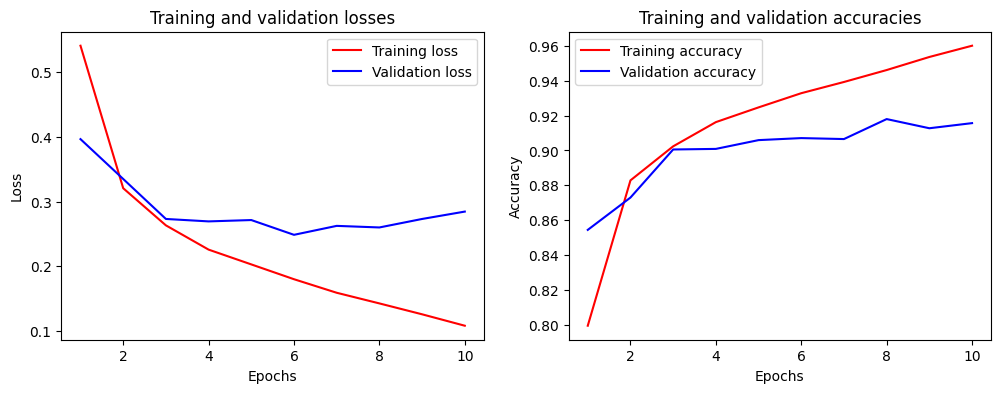

In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and validation losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


Confusion Matrix

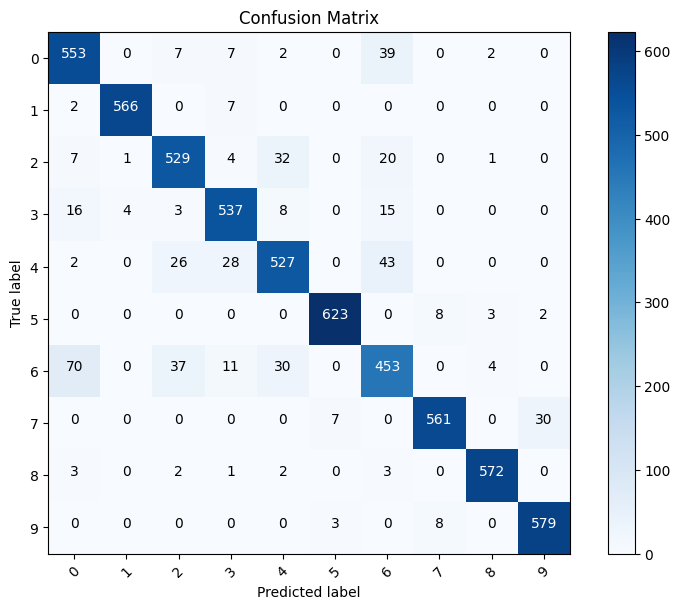

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = [str(i) for i in range(10)]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names)
plt.show()


Now experimenting with hyperparameters!!!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

# Hyperparameters
kernel_sizes = [3, 5]
num_filters = [32, 64, 128]
weight_initialization_methods = ['random', 'xavier', 'he']

class CNN(nn.Module):
    def __init__(self, kernel_size, num_filters, weight_init):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters[0], kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=kernel_size, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self._initialize_weights(weight_init)

    def _initialize_weights(self, method):
        if method == 'random':
            initializer = nn.init.normal_
        elif method == 'xavier':
            initializer = nn.init.xavier_normal_
        elif method == 'he':
            initializer = nn.init.kaiming_normal_

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                initializer(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        return x

def train_cnn(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            images, labels = batch
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for batch in val_loader:
                images, labels = batch
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)

            val_loss /= len(val_loader)
            val_acc /= len(val_loader)
            print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

def accuracy(output, y):
    predictions = np.argmax(output.numpy(), axis=1)
    return np.mean(predictions == y.numpy())

# Prepare dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_length = int(0.8 * len(dataset))
val_length = len(dataset) - train_length
train_dataset, val_dataset = random_split(dataset, [train_length, val_length])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Experiment with different configurations
for kernel_size in kernel_sizes:
    for num_filter in num_filters:
        for weight_init in weight_initialization_methods:
            print(f'Kernel Size: {kernel_size}, Num Filters: {num_filter}, Weight Init: {weight_init}')
            cnn_model = CNN(kernel_size, [num_filter]*3, weight_init)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
            train_cnn(cnn_model, train_loader, val_loader, criterion, optimizer, epochs=10)


Kernel Size: 3, Num Filters: 32, Weight Init: random
Epoch 1, Validation Loss: 5.8919, Validation Accuracy: 0.0977
Epoch 2, Validation Loss: 5.6911, Validation Accuracy: 0.0995
Epoch 3, Validation Loss: 5.6756, Validation Accuracy: 0.0996
Epoch 4, Validation Loss: 5.6711, Validation Accuracy: 0.0999
Epoch 5, Validation Loss: 5.6699, Validation Accuracy: 0.0999
Epoch 6, Validation Loss: 5.6699, Validation Accuracy: 0.0998
Epoch 7, Validation Loss: 5.6647, Validation Accuracy: 0.1006
Epoch 8, Validation Loss: 5.6217, Validation Accuracy: 0.1083
Epoch 9, Validation Loss: 5.3041, Validation Accuracy: 0.1714
Epoch 10, Validation Loss: 5.3422, Validation Accuracy: 0.1582
Kernel Size: 3, Num Filters: 32, Weight Init: xavier
Epoch 1, Validation Loss: 1.6961, Validation Accuracy: 0.5887
Epoch 2, Validation Loss: 1.5188, Validation Accuracy: 0.6333
Epoch 3, Validation Loss: 1.4266, Validation Accuracy: 0.6572
Epoch 4, Validation Loss: 1.3770, Validation Accuracy: 0.6669
Epoch 5, Validation Loss:

After finding the best configuration for the CNN, we will extract the features and train an MLP.